# 1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 2 — Upload the CSV manually

In [2]:
# Step 2: Upload CSV file manually
from google.colab import files
uploaded = files.upload()

# Load the first uploaded file into a pandas DataFrame
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)

df.head()

Saving customer_behavior.csv to customer_behavior.csv


,CustomerID,Gender,Region,PurchaseAmount,ProductCategory,Churn,CampaignGroup
0,1001,Male,South,256.07,Fashion,No,A
1,1002,Female,South,NaN,Electronics,Yes,B
2,1003,Female,West,1194.41,Fashion,No,A
3,1004,Female,South,413.06,Grocery,No,A
4,1005,Male,West,1556.32,Fashion,Yes,A


# 3 — Clean & prepare

In [3]:
# Step 3: Basic cleaning
df.columns = [c.strip() for c in df.columns]  # tidy column names
# Force types
df["PurchaseAmount"] = pd.to_numeric(df["PurchaseAmount"], errors="coerce")
df["Gender"] = df["Gender"].astype("category")
df["Region"] = df["Region"].astype("category")
df["ProductCategory"] = df["ProductCategory"].astype("category")
df["Churn"] = df["Churn"].astype("category")
df["CampaignGroup"] = df["CampaignGroup"].astype("category")

# Work series without NaN for amount
pa = df["PurchaseAmount"].dropna()
n = len(pa)
n

4850

# 4 - 📊 Mean, Median, Mode of PurchaseAmount

In [4]:
mean_val = pa.mean()
median_val = pa.median()
mode_vals = pa.mode()  # could be multimodal
mode_val = mode_vals.iloc[0] if len(mode_vals) > 0 else np.nan

print(f"Mean:   {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Mode:   {mode_val:.2f}")

Mean:   1003.95
Median: 998.08
Mode:   0.00


# 5 - 🚨 Outliers (IQR method)

In [5]:
q1, q3 = pa.quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = pa[(pa < lower) | (pa > upper)]
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
print(f"Outliers count: {outliers.shape[0]}")
outliers

Lower bound: -306.51, Upper bound: 2307.23
Outliers count: 15


,PurchaseAmount
195,2318.33
265,2496.41
348,2688.69
411,2349.16
826,2578.89
1358,2384.19
2285,2457.05
2557,2316.19
2681,2400.69
3326,2357.41


# 6 - 📐 Skewness & Kurtosis + Plots

Skewness: 0.106
Kurtosis: -0.262  (Fisher; 0 == normal)


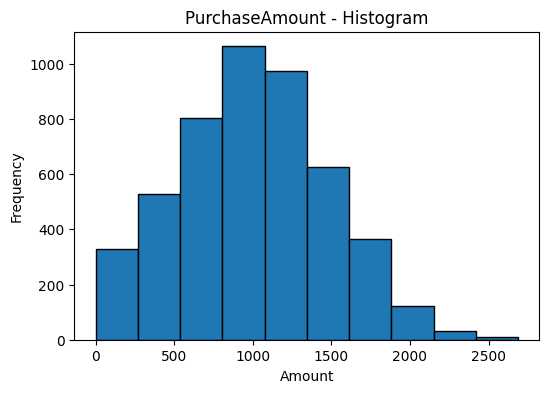

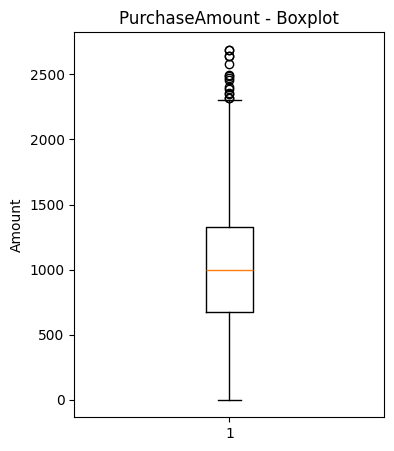

In [6]:
skew = stats.skew(pa, bias=False)
kurt = stats.kurtosis(pa, bias=False)  # Fisher's definition; Normal==0

print(f"Skewness: {skew:.3f}")
print(f"Kurtosis: {kurt:.3f}  (Fisher; 0 == normal)")

# Histogram
plt.figure(figsize=(6,4))
plt.hist(pa, bins=10, edgecolor="black")
plt.title("PurchaseAmount - Histogram")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Boxplot
plt.figure(figsize=(4,5))
plt.boxplot(pa.dropna(), vert=True)
plt.title("PurchaseAmount - Boxplot")
plt.ylabel("Amount")
plt.show()

# 7 - ♂️♀️ Male vs Female Spend — Welch’s t-test

In [7]:
male_amt = df.loc[(df["Gender"]=="Male") & df["PurchaseAmount"].notna(), "PurchaseAmount"]
female_amt = df.loc[(df["Gender"]=="Female") & df["PurchaseAmount"].notna(), "PurchaseAmount"]

print(f"Male mean:   {male_amt.mean():.2f} (n={len(male_amt)})")
print(f"Female mean: {female_amt.mean():.2f} (n={len(female_amt)})")

t_stat, p_val = stats.ttest_ind(male_amt, female_amt, equal_var=False, nan_policy='omit')
print(f"Welch t-test: t={t_stat:.3f}, p={p_val:.4f}")

Male mean:   1019.18 (n=2386)
Female mean: 987.87 (n=2370)
Welch t-test: t=2.235, p=0.0255


# 8 - 🧮 ProductCategory vs Churn — Chi-square test (+ Cramér’s V)

In [8]:
# Drop rows with missing ProductCategory or Churn
ct = pd.crosstab(df["ProductCategory"], df["Churn"])
chi2, p, dof, expected = stats.chi2_contingency(ct)

# Cramér’s V
n_obs = ct.to_numpy().sum()
phi2 = chi2 / n_obs
r, k = ct.shape
cramers_v = np.sqrt( phi2 / (min(r-1, k-1)) ) if min(r-1, k-1) > 0 else np.nan

print(ct)
print(f"\nChi-square: {chi2:.3f}, dof={dof}, p={p:.4f}")
print(f"Cramér's V: {cramers_v:.3f}  (0=none, 1=strong)")

Churn             No  Yes
ProductCategory          
Electronics      785  541
Fashion          839  607
Grocery          855  604

Chi-square: 0.396, dof=2, p=0.8204
Cramér's V: 0.010  (0=none, 1=strong)


# 9 - 🌍 PurchaseAmount across Regions — One-way ANOVA (+ Kruskal)

In [9]:
groups = [g["PurchaseAmount"].dropna() for _, g in df.groupby("Region")]
labels = list(df["Region"].cat.categories)

# ANOVA (parametric)
f_stat, p_anova = stats.f_oneway(*groups)
print(f"ANOVA: F={f_stat:.3f}, p={p_anova:.4f}")

# Kruskal-Wallis (nonparametric)
h_stat, p_kruskal = stats.kruskal(*groups)
print(f"Kruskal-Wallis: H={h_stat:.3f}, p={p_kruskal:.4f}")

# Show means per region
means_by_region = df.groupby("Region", dropna=True)["PurchaseAmount"].mean().sort_values()
means_by_region

ANOVA: F=0.390, p=0.7605
Kruskal-Wallis: H=0.857, p=0.8357


/tmp/ipython-input-2766585497.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g["PurchaseAmount"].dropna() for _, g in df.groupby("Region")]
/tmp/ipython-input-2766585497.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_by_region = df.groupby("Region", dropna=True)["PurchaseAmount"].mean().sort_values()


,PurchaseAmount
Region,
West,995.247327
South,997.603877
East,1009.946017
North,1013.017952


# 10 - ✉️ Campaign A vs B — Means + Welch t-test

In [10]:
campA = df.loc[(df["CampaignGroup"]=="A") & df["PurchaseAmount"].notna(), "PurchaseAmount"]
campB = df.loc[(df["CampaignGroup"]=="B") & df["PurchaseAmount"].notna(), "PurchaseAmount"]

print(f"Campaign A mean: {campA.mean():.2f} (n={len(campA)})")
print(f"Campaign B mean: {campB.mean():.2f} (n={len(campB)})")

t_stat, p_val = stats.ttest_ind(campA, campB, equal_var=False)
print(f"Welch t-test: t={t_stat:.3f}, p={p_val:.4f}")

Campaign A mean: 1011.95 (n=2350)
Campaign B mean: 994.34 (n=2318)
Welch t-test: t=1.243, p=0.2139


# 11 - 🧪 Normality test (D’Agostino) + Q–Q plot

D’Agostino test: statistic=27.252, p=0.0000
Interpretation: p>0.05 → cannot reject normality (approx normal).


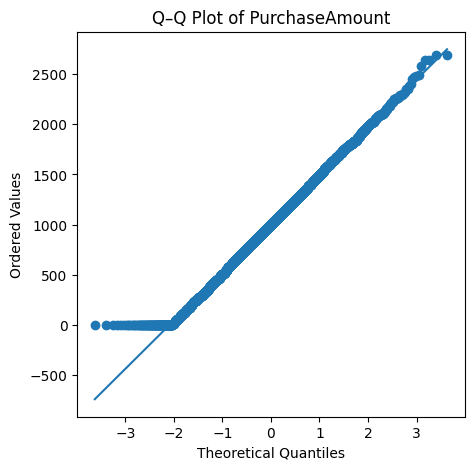

In [11]:
# D’Agostino & Pearson test
k2, p_norm = stats.normaltest(pa)
print(f"D’Agostino test: statistic={k2:.3f}, p={p_norm:.4f}")
print("Interpretation: p>0.05 → cannot reject normality (approx normal).")

# Q-Q plot
import scipy.stats as sps
osm, osr = sps.probplot(pa, dist="norm")[:2]
plt.figure(figsize=(5,5))
plt.scatter(osm[0], osm[1])
plt.plot(osm[0], osr[0]*osm[0] + osr[1])  # fitted line
plt.title("Q–Q Plot of PurchaseAmount")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

# 12 - 🎯 Central Limit Theorem (simulate sampling distributions)

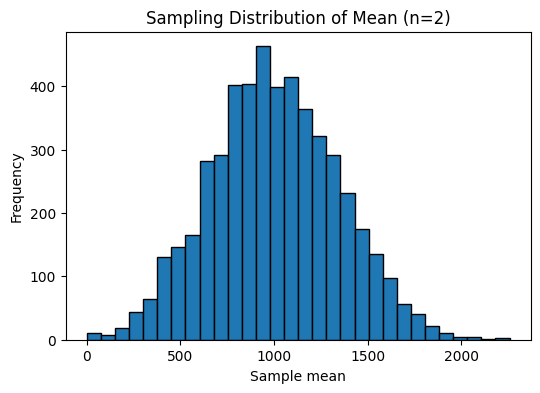

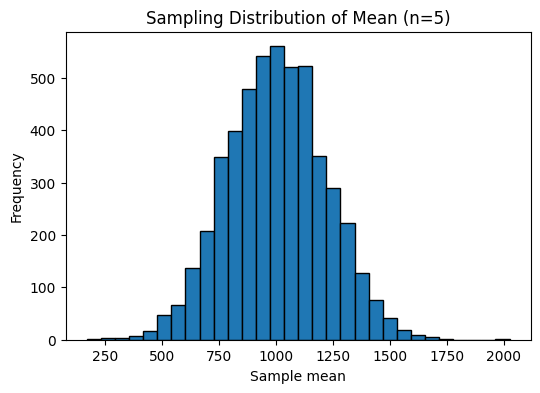

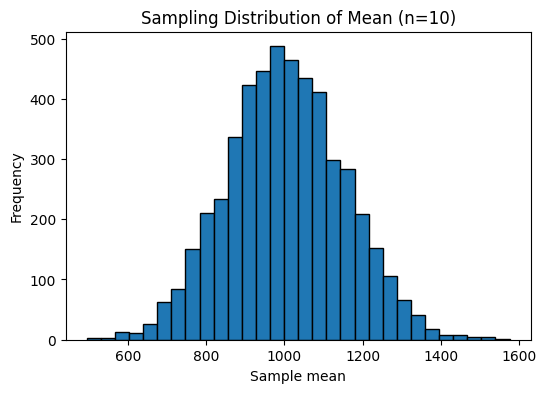

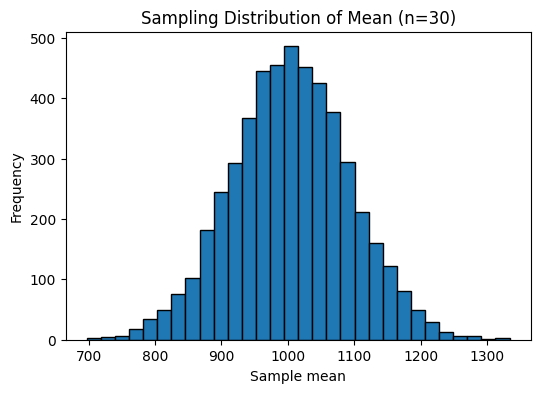

In [12]:
rng = np.random.default_rng(42)

def sample_means(x, size, reps=5000):
    means = [rng.choice(x, size=size, replace=True).mean() for _ in range(reps)]
    return np.array(means)

for m in [2, 5, 10, 30]:
    sm = sample_means(pa.values, size=m)
    plt.figure(figsize=(6,4))
    plt.hist(sm, bins=30, edgecolor="black")
    plt.title(f"Sampling Distribution of Mean (n={m})")
    plt.xlabel("Sample mean")
    plt.ylabel("Frequency")
    plt.show()

# 13 - 📏 95% Confidence Interval for Mean (t-interval)

In [14]:
import math

mean_ = pa.mean()
sd_ = pa.std(ddof=1)
n_ = len(pa)
alpha = 0.05

tcrit = stats.t.ppf(1 - alpha/2, df=n_-1)
se_ = sd_ / math.sqrt(n_)

ci_low = mean_ - tcrit * se_
ci_high = mean_ + tcrit * se_

print(f"Mean = {mean_:.2f}")
print(f"95% CI (t) = ({ci_low:.2f}, {ci_high:.2f})")

Mean = 1003.95
95% CI (t) = (990.38, 1017.52)


# Quick result summary table

In [15]:
summary = {
    "Mean": round(mean_val, 2),
    "Median": round(median_val, 2),
    "Mode": round(mode_val, 2),
    "Skewness": round(skew, 3),
    "Kurtosis": round(kurt, 3),
    "Outliers_Count": int(outliers.shape[0]),
}
pd.Series(summary)

,0
Mean,1003.950
Median,998.080
Mode,0.000
Skewness,0.106
Kurtosis,-0.262
Outliers_Count,15.000
